In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import make_interp_spline
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
roc_curve, auc, confusion_matrix, classification_report, brier_score_loss)
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import resample
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import mode
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler
import joblib
import os
import sys
import shutil
from sklearn.exceptions import NotFittedError
from sklearn.utils.validation import check_is_fitted
import seaborn as sns
from collections import defaultdict

In [2]:
# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
from utilities import bs_calibrate, bs_results, utils

# DATA PREPRATION

In [4]:
df = pd.read_csv("/Users/chufal/projects/DIBHproject/dibh_clinical_only/original_training_data.csv")
data_day1 = df[df['day'] == 1]
X = data_day1.drop(['crnumber', 'day', 'DIBH_Y0N1'], axis=1)
y = data_day1['DIBH_Y0N1']
X_t, X_v, y_t, y_v = train_test_split(X, y, test_size=0.30, random_state=42)

df_internal_val = pd.read_csv("/Users/chufal/projects/DIBHproject/dibh_clinical_only/final_internal_validation13052024.csv")
data_day1_val = df_internal_val[df_internal_val['day'] == 1]
X_int_val = data_day1_val.drop(['crnumber', 'day', 'DIBH_Y0N1'], axis=1)
y_int_val = data_day1_val['DIBH_Y0N1']

categorical_features = ['al_N0_Y1', 'surgery_BCS1MRM2', 'chemo_No0_Adj1_NAdj2', 'comorb_no0_cardio1_others2']
continuous_features = ['age', 'BMI', 'ul_amp', 'll_amp', 'average_amp', 'ahd']

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, continuous_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# HYPERPARAMETER OPTIMIZATION

## Naive Bayes does not have hyperparameters to tune

In [5]:
# def objective(trial):
#     # Naive Bayes does not have hyperparameters to tune
#     return cross_val_score(make_pipeline(preprocessor, GaussianNB()), X_t, y_t, cv=10, scoring='roc_auc').mean()

In [6]:
# storage_name = "sqlite:///db.sqlite3"
# sampler = TPESampler(seed=42)
# study = optuna.create_study(direction='maximize', sampler=sampler, storage=storage_name, study_name="NB_one_day_assessment_final")
# study.optimize(objective, n_trials=10)  # Only a few trials needed as no hyperparameters

In [7]:
# loaded_study = optuna.create_study(study_name="NB_one_day_assessment_final", storage=storage_name, load_if_exists=True)
# best_params = loaded_study.best_params

# Bootstraping and calibration

In [8]:
# For Gradient Boosting
top_models_nb, results_nb, calibration_data_nb = bs_calibrate.new_bootstrap_model_evaluation(
    X_t, y_t, X_v, y_v, preprocessor, GaussianNB
)

Bootstrap sample no. 25 ------ Finished
Bootstrap sample no. 50 ------ Finished
Bootstrap sample no. 75 ------ Finished
Bootstrap sample no. 100 ------ Finished
Bootstrap sample no. 125 ------ Finished
Bootstrap sample no. 150 ------ Finished
Bootstrap sample no. 175 ------ Finished
Bootstrap sample no. 200 ------ Finished
Bootstrap sample no. 225 ------ Finished
Bootstrap sample no. 250 ------ Finished
Bootstrap sample no. 275 ------ Finished
Bootstrap sample no. 300 ------ Finished
Bootstrap sample no. 325 ------ Finished
Bootstrap sample no. 350 ------ Finished
Bootstrap sample no. 375 ------ Finished
Bootstrap sample no. 400 ------ Finished
Bootstrap sample no. 425 ------ Finished
Bootstrap sample no. 450 ------ Finished
Bootstrap sample no. 475 ------ Finished
Bootstrap sample no. 500 ------ Finished
Bootstrap sample no. 525 ------ Finished
Bootstrap sample no. 550 ------ Finished
Bootstrap sample no. 575 ------ Finished
Bootstrap sample no. 600 ------ Finished
Bootstrap sample no

## Saving Data

In [9]:
joblib.dump(top_models_nb, 'results/bs_training_data/python_objects/top_models_nb.joblib')
joblib.dump(results_nb, 'results/bs_training_data/python_objects/results_nb.joblib')
joblib.dump(calibration_data_nb, 'results/bs_training_data/python_objects/calibration_data_nb.joblib')

['results/bs_training_data/python_objects/calibration_data_nb.joblib']

## Plotting and calibration curve

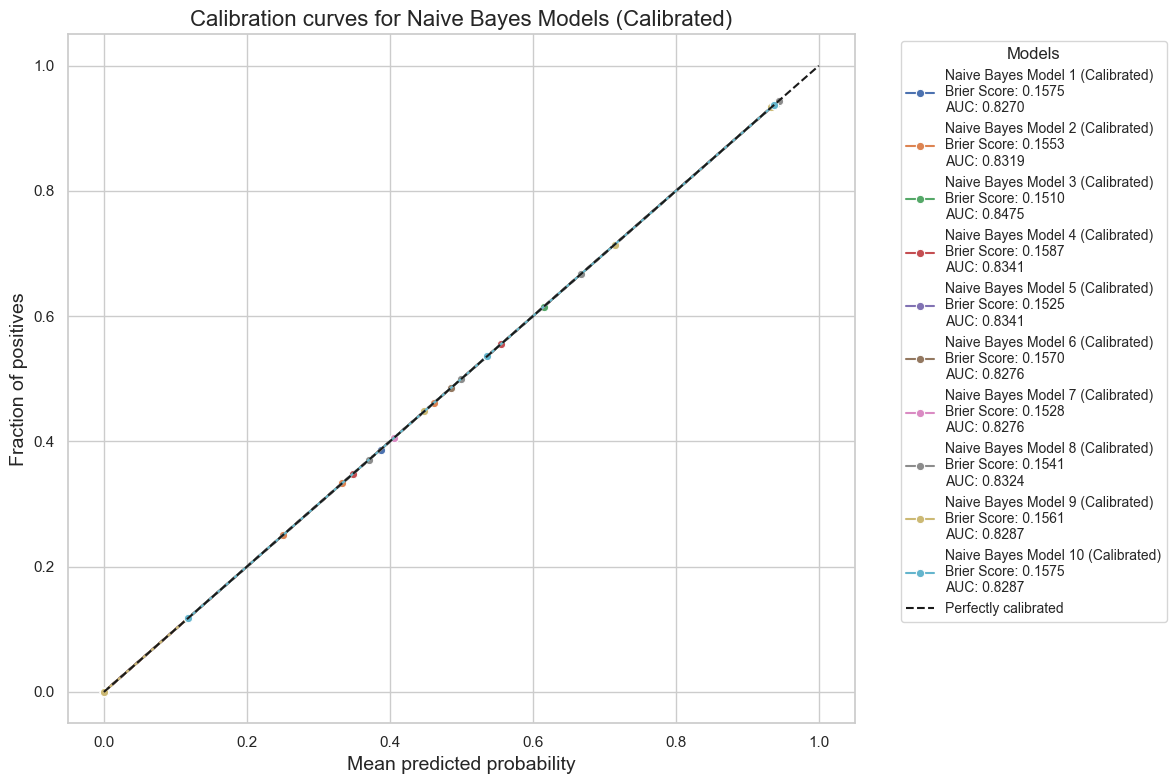

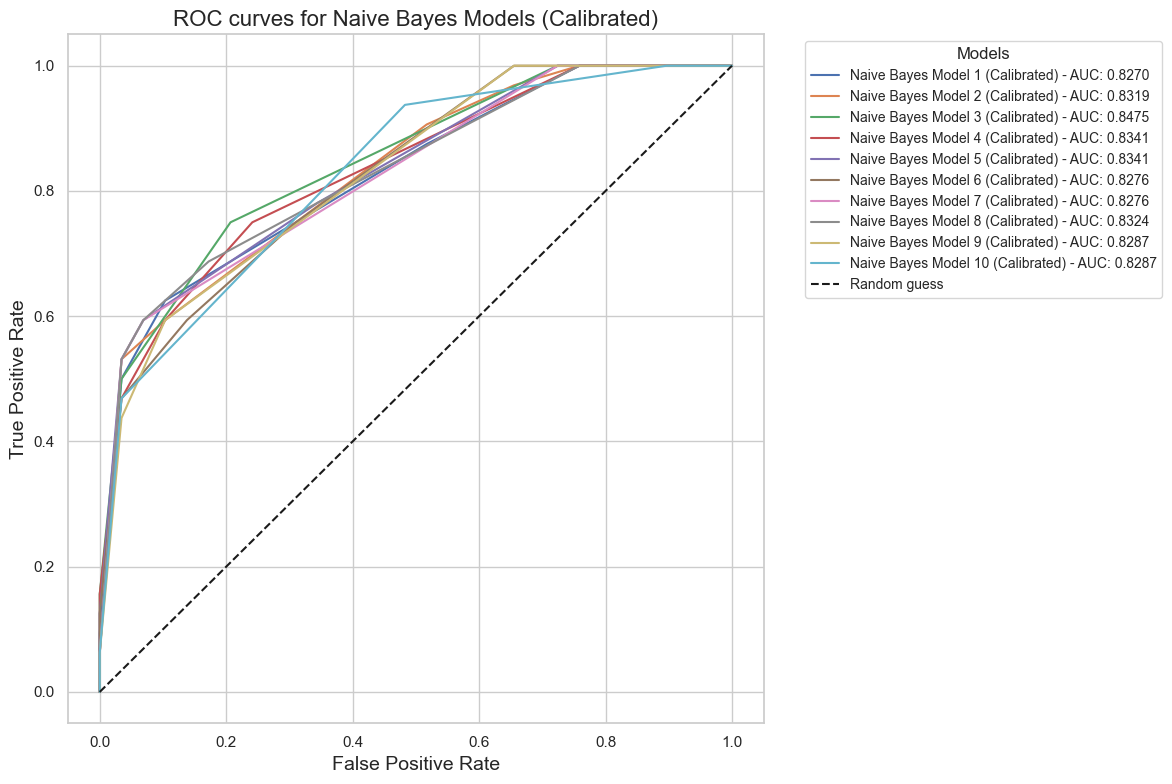

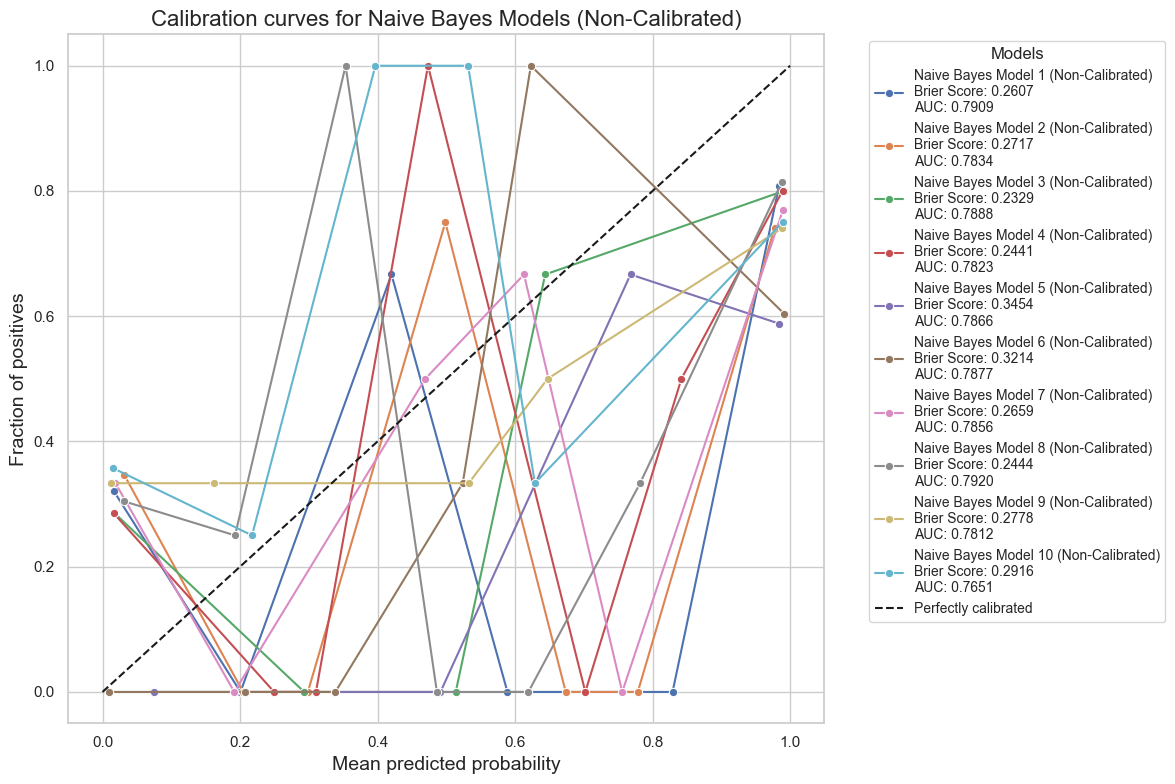

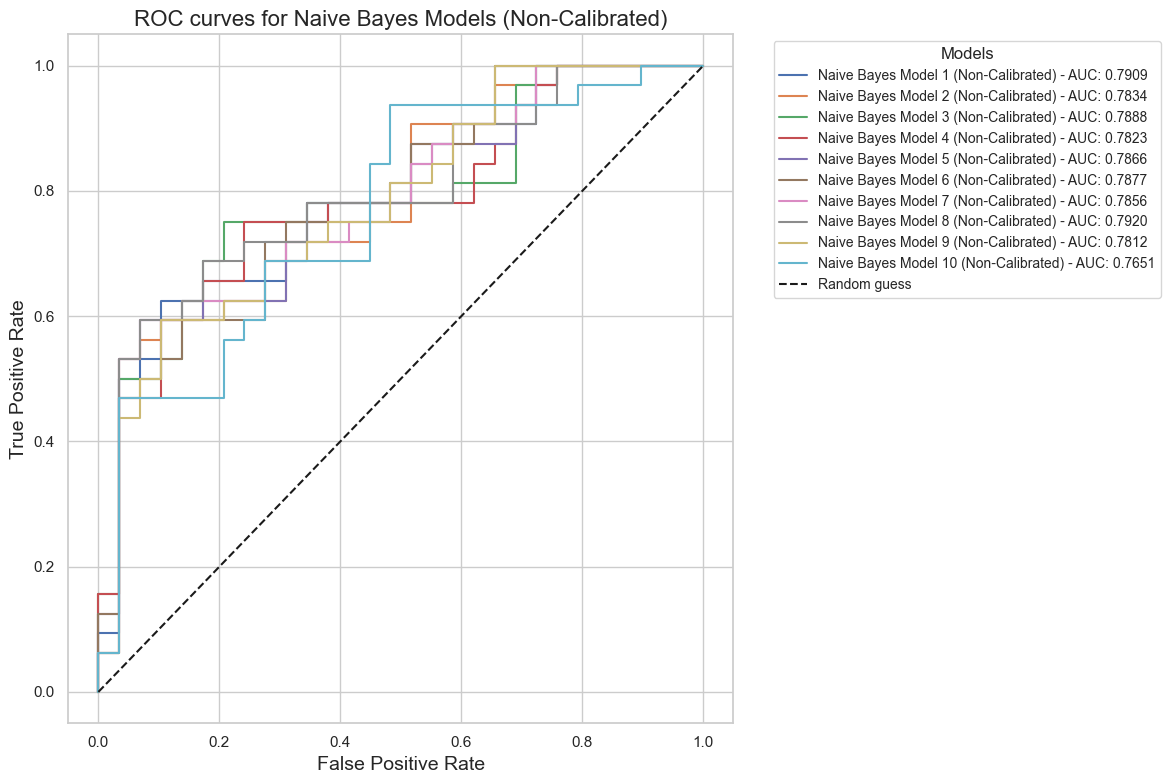

In [10]:
# Assuming calibration_data_gb and calibration_data_cat have the top 10 predicted probabilities
# for Gradient Boosting models
loaded_calibration_data = joblib.load('results/bs_training_data/python_objects/calibration_data_nb.joblib')
# Example: Plotting calibration curves for top 10 Gradient Boosting models
utils.plot_individual_calibration_curves(y_v, loaded_calibration_data['top_predicted_proba_calibrated'], n_bins=7, model_label="Naive Bayes", calibrated=True)
utils.plot_individual_calibration_curves(y_v, loaded_calibration_data['top_predicted_proba_non_calibrated'], n_bins=7, model_label="Naive Bayes", calibrated=False)



## Extract feature importances and save them in a csv file

In [11]:
# Save to CSV
df_importances = utils.save_feature_importances_to_csv(filename='results/bs_training_data/csv/feature_importances_nb.csv', 
                                                       model_name_prefix='nb', 
                                                       top_models_path='results/bs_training_data/python_objects/top_models_nb.joblib')

Data saved to - results/bs_training_data/csv/feature_importances_nb.csv


## Plot feature importance

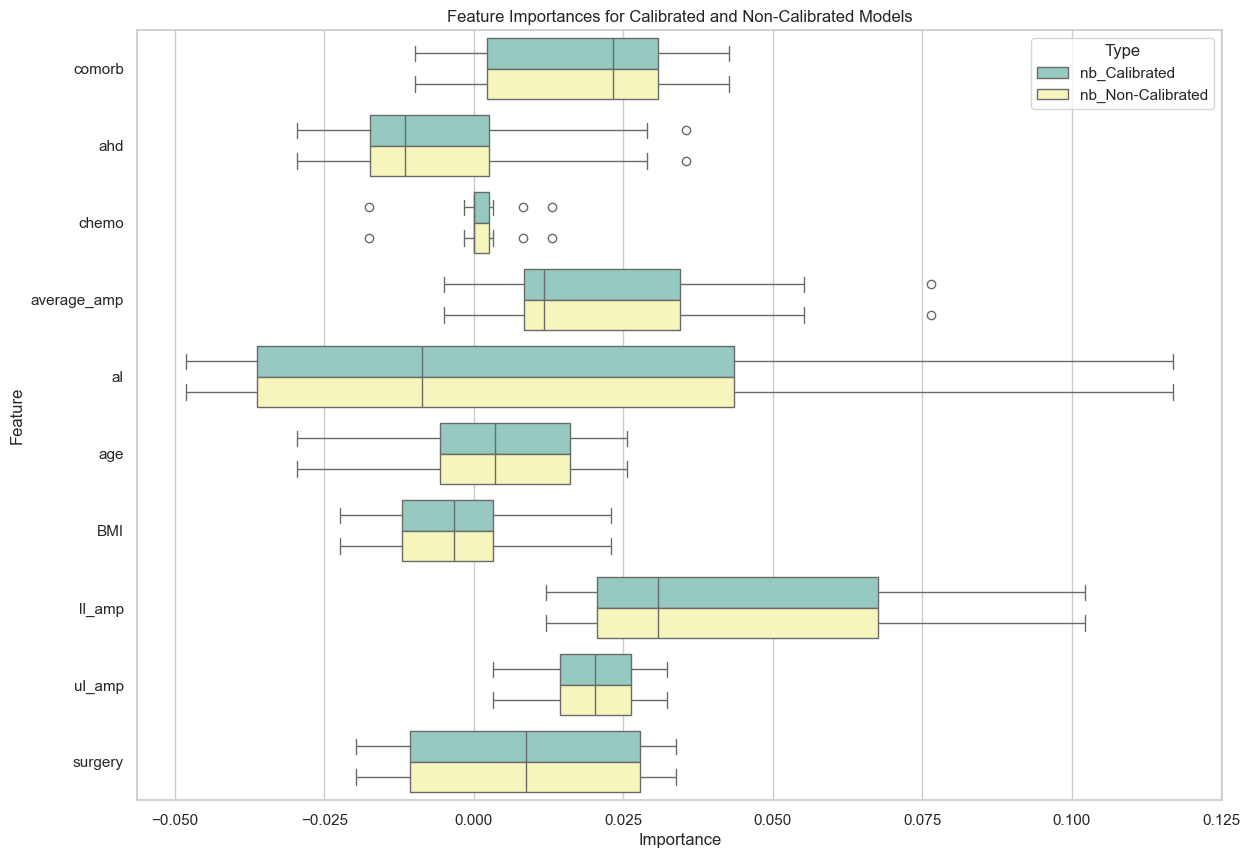

In [12]:
# Box plot
plt.figure(figsize=(14, 10))
sns.boxplot(x='Importance', y='Feature', hue='Type', data=df_importances, palette='Set3')
plt.title('Feature Importances for Calibrated and Non-Calibrated Models')
plt.show()

## Store the results for models into a csv file

In [13]:
loaded_results = joblib.load('results/bs_training_data/python_objects/results_nb.joblib')
calibrated_summary, non_calibrated_summary = bs_results.get_results(loaded_results)

Calibrated Model Metrics Summary
              accuracy  precision    recall  f1_score   roc_auc
mean          0.697787   0.850818  0.543344  0.647065  0.782091
std           0.015883   0.091707  0.122365  0.049106  0.023782
min           0.655738   0.650000  0.406250  0.565217  0.692349
max           0.770492   0.947368  0.937500  0.789474  0.847522
95% CI lower  0.666656   0.671072  0.303508  0.550818  0.735478
95% CI upper  0.728918   1.030563  0.783179  0.743313  0.828704

Non-Calibrated Model Metrics Summary
              accuracy  precision    recall  f1_score   roc_auc
mean          0.697787   0.850818  0.543344  0.647065  0.739503
std           0.015883   0.091707  0.122365  0.049106  0.022182
min           0.655738   0.650000  0.406250  0.565217  0.654095
max           0.770492   0.947368  0.937500  0.789474  0.792026
95% CI lower  0.666656   0.671072  0.303508  0.550818  0.696026
95% CI upper  0.728918   1.030563  0.783179  0.743313  0.782980


In [14]:
filename='results/bs_training_data/csv/final_results.csv'
model_name = 'NB'
bs_results.save_results_to_csv(calibrated_summary, non_calibrated_summary, filename=filename, model_name=model_name)

'Data saved to results/bs_training_data/csv/final_results.csv'

# Model Building without Bootstraping

In [16]:
non_bs_model, results_calibrated, results_non_calibrated = bs_calibrate.get_calibrated_model(X_t, y_t, X_v, y_v, preprocessor, 
                                                          GaussianNB,
                                                         model_name_prefix="nb", csv_filename="results/non_bs_training_data/csv/model_metrics.csv")


Metrics saved to results/non_bs_training_data/csv/model_metrics.csv


In [17]:
results_calibrated['Brier Score'], results_non_calibrated['Brier Score']

(0.1722801788375559, 0.3087985233291816)

In [18]:
joblib.dump(non_bs_model, 'results/non_bs_training_data/models/non_bs_model_nb.joblib')
joblib.dump(results_calibrated, 'results/non_bs_training_data/python_objects/results_calibrated_nb.joblib')
joblib.dump(results_non_calibrated, 'results/non_bs_training_data/python_objects/results_non_calibrated_nb.joblib')

['results/non_bs_training_data/python_objects/results_non_calibrated_nb.joblib']